## Import


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eda_helper_functions
from sklearn.ensemble import IsolationForest

## Read the training data


In [3]:
PROJECT_DIR = r"c:\Data-Science\CampusX\sagemaker-flight-prices-prediction-proj"

TRAIN_DATA_FILE_PATH = "{}/data/train.csv".format(PROJECT_DIR)
TEST_DATA_FILE_PATH = "{}/data/test.csv".format(PROJECT_DIR)

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE_PATH)
train.sample(5)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
256,Air India,2019-04-27,Delhi,Cochin,05:15:00,06:50:00,1535,1.0,No Info,6587
260,Indigo,2019-06-03,Delhi,Cochin,04:55:00,21:00:00,965,1.0,No Info,6838
163,Jet Airways,2019-06-27,Delhi,Cochin,19:30:00,12:35:00,1025,2.0,No Info,13764
49,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,23:25:00,385,1.0,No Info,8610
286,Jet Airways,2019-05-09,Banglore,Delhi,18:55:00,22:00:00,185,0.0,No Info,7229


In [5]:
train.shape

(640, 10)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [8]:
train = train.assign(
    **{
        col: pd.to_datetime(train.loc[:, col], dayfirst=True)
        for col in ["date_of_journey", "dep_time", "arrival_time"]
    }
)

In [9]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [10]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,2024-05-01 10:20:00,2024-05-01 11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,2024-05-01 09:00:00,2024-05-01 07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,2024-05-01 09:10:00,2024-05-01 11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,2024-05-01 20:20:00,2024-05-01 22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,2024-05-01 17:00:00,2024-05-01 10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,2024-05-01 04:55:00,2024-05-01 07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,2024-05-01 09:35:00,2024-05-01 21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,2024-05-01 06:05:00,2024-05-01 08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,2024-05-01 08:45:00,2024-05-01 21:00:00,735,1.0,No Info,7670


### High Level Analysis of the data set


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [12]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,639.773438,0.792188,9075.418750
std,502.047906,0.654060,4328.022872
min,75.000000,0.000000,1965.000000
25%,175.000000,0.000000,5636.250000
50%,505.000000,1.000000,8372.000000
75%,956.250000,1.000000,12386.750000
max,2565.000000,3.000000,34273.000000


In [13]:
train.describe(include="object")

,airline,source,destination,additional_info
count,640,640,640,640
unique,8,5,6,4
top,Jet Airways,Delhi,Cochin,No Info
freq,248,263,263,488


In [14]:
(train.assign(total_stops=train["total_stops"].astype(object)).describe(include="O"))

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,4
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,248,263,263,351.0,488


## High Level Analysis of missing values in the dataset


In [15]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


In [17]:
temp = pd.read_csv(r"C:\Data-Science\CampusX\data\Titanic-Dataset.csv")
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
eda_helper_functions.missing_info(temp)

,count,percentage
variable,,
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


In [21]:
[col for col in temp.columns if temp[col].isna().any()]

['Age', 'Cabin', 'Embarked']

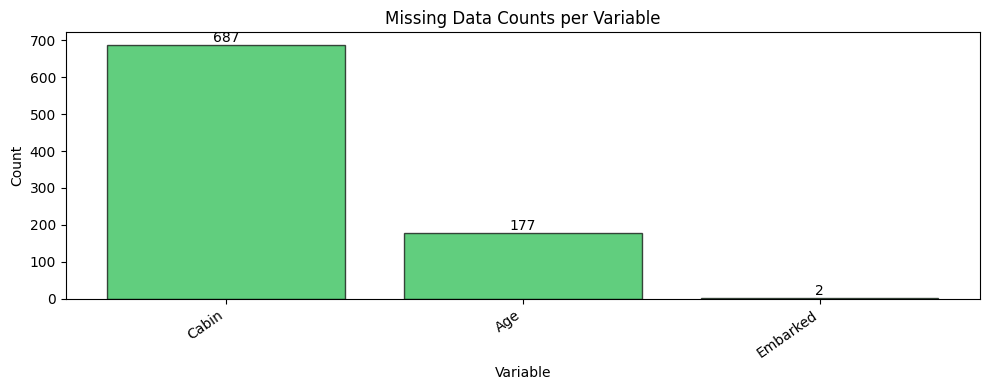

In [22]:
eda_helper_functions.plot_missing_info(temp)

### Highlevel Analysis of outlier


In [24]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [28]:
(
    train 
    .assign(outlier=forest.fit_predict(train
                                       .drop(columns='price')
                                       .select_dtypes(include="number")))
    .query("outlier == -1")
    # .duration
    # .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,2024-05-01 10:20:00,2024-05-01 11:50:00,90,0.0,In-flight meal not included,4995,-1
1,Air India,2019-05-18,Delhi,Cochin,2024-05-01 09:00:00,2024-05-01 07:40:00,1360,1.0,No Info,8372,-1
2,Air India,2019-06-12,Kolkata,Banglore,2024-05-01 09:10:00,2024-05-01 11:05:00,1555,2.0,No Info,6117,-1
3,Vistara,2019-04-01,Kolkata,Banglore,2024-05-01 20:20:00,2024-05-01 22:55:00,1595,1.0,No Info,7770,-1
4,Vistara,2019-06-06,Kolkata,Banglore,2024-05-01 17:00:00,2024-05-01 10:45:00,1065,1.0,No Info,9187,-1
...,...,...,...,...,...,...,...,...,...,...,...
626,Spicejet,2019-05-09,Mumbai,Hyderabad,2024-05-01 05:45:00,2024-05-01 07:15:00,90,0.0,No check-in baggage included,1965,-1
627,Air India,2019-03-21,Delhi,Cochin,2024-05-01 19:45:00,2024-05-01 19:15:00,1410,2.0,No Info,8236,-1
630,Air India,2019-05-12,Kolkata,Banglore,2024-05-01 10:00:00,2024-05-01 01:20:00,920,2.0,No Info,13243,-1
632,Jet Airways,2019-03-24,Kolkata,Banglore,2024-05-01 21:10:00,2024-05-01 22:35:00,1525,1.0,In-flight meal not included,10031,-1


### Pairplot

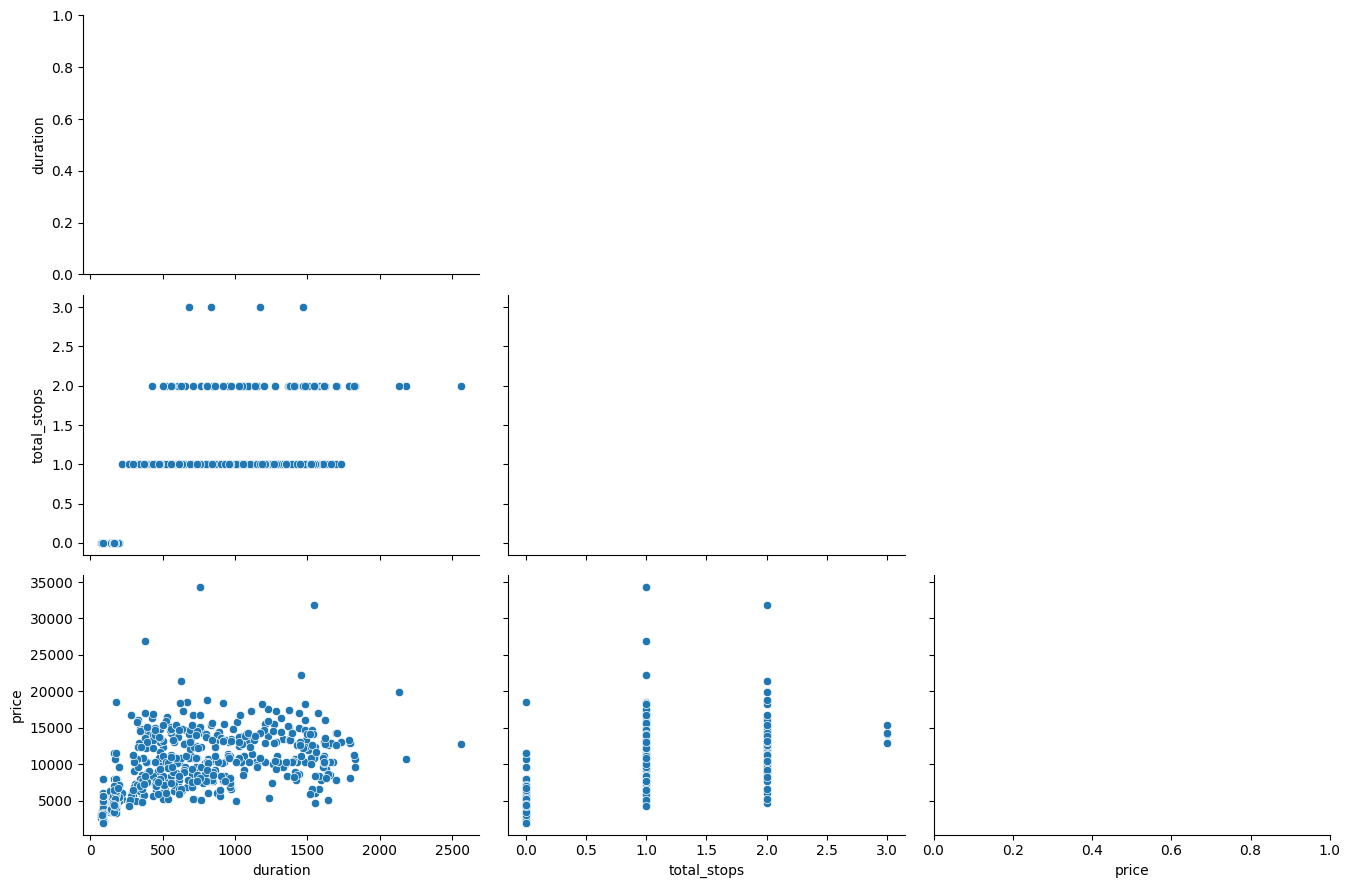

In [29]:
eda_helper_functions.pair_plots(train)

### Correlation Analysis

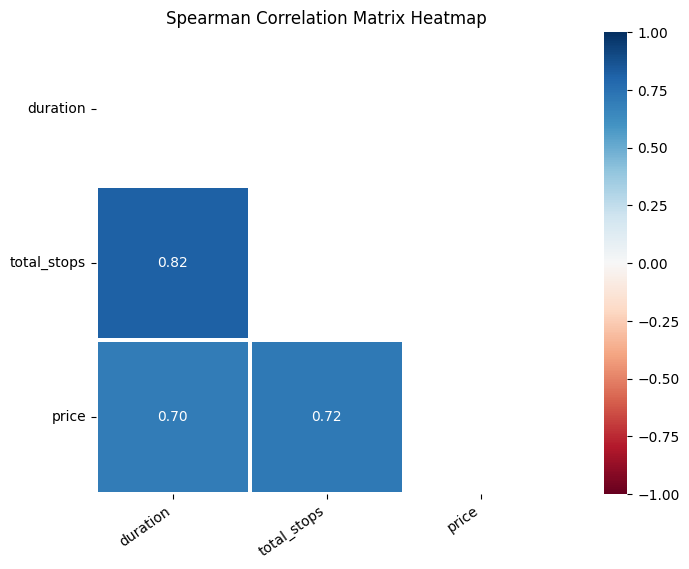

In [30]:
eda_helper_functions.correlation_heatmap(train)

In [35]:
cm = train.corr(method='spearman', numeric_only=True)

mask = np.zeros_like(cm, dtype=bool)

mask[np.triu_indices_from(mask)] = True 

mask 

array([[ True,  True,  True],
       [False,  True,  True],
       [False, False,  True]])

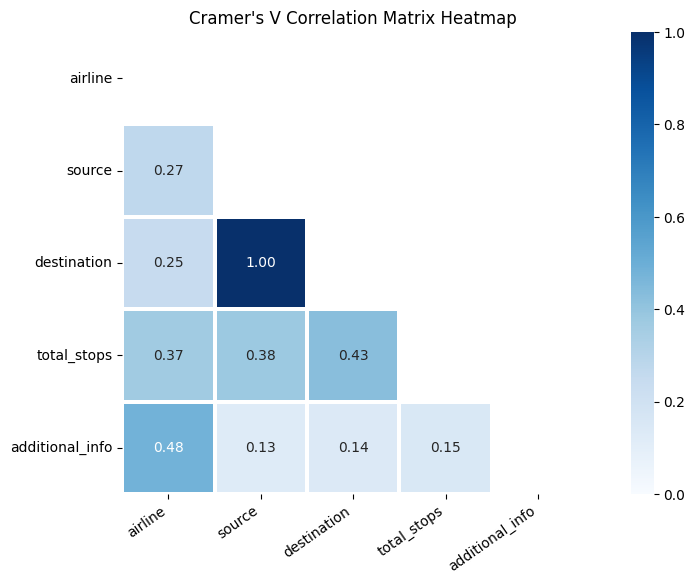

In [37]:
eda_helper_functions.cramersV_heatmap(train.assign(total_stops=train["total_stops"].astype("object")))

In [44]:
cols = train.select_dtypes(include="object").columns.to_list()

matrix = (
    pd
    .DataFrame(data = np.ones((len(cols), len(cols))))
    .set_axis(cols, axis=0)
    .set_axis(cols, axis=1)
)

matrix 


,airline,source,destination,additional_info
airline,1.0,1.0,1.0,1.0
source,1.0,1.0,1.0,1.0
destination,1.0,1.0,1.0,1.0
additional_info,1.0,1.0,1.0,1.0


In [48]:
ct = pd.crosstab(train.loc[:,"airline"], train.loc[:,"source"])
ct 

source,Banglore,Chennai,Delhi,Kolkata,Mumbai
airline,,,,,
Air Asia,9,0,1,8,0
Air India,16,0,42,31,13
Goair,6,0,7,0,0
Indigo,25,11,41,28,10
Jet Airways,61,0,98,76,13
Multiple Carriers,0,0,68,0,0
Spicejet,11,3,2,16,8
Vistara,17,1,4,13,1


In [56]:
n = ct.sum().sum()
r, c = ct.shape 

r, c, n 

(8, 5, 640)

In [55]:
import scipy.stats as stats
chi2 = stats.chi2_contingency(ct).statistic
phi2 = chi2/ n 
phi2 

0.33782780247748295